# Определение перспективного тарифа для телеком компании

### p.s. Анализ БЕЗ применения ML

### В рамках работ предстоит проанализировать показатели двух тарифных планов: «Смарт» и «Ультра»:
- определить количество звонков/минут разговора/СМС/трафика по месяцам
- расчитать помесячную выручку с каждого пользователя
- описать поведения пользователей в части используемых едениц тарифа в месяц
- проверить гипотезы:
    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

# 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

---
**Звонки**

Рассмотрим данные по звонкам:

In [2]:
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


Взглянем на гистограмму продолжительности разговоров:

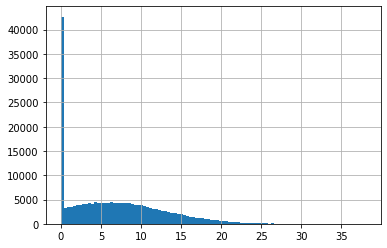

In [3]:
calls['duration'].hist(bins=100)

In [4]:
calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Большое количество звонков с длительностью 0 минут, судя по всему, это пропущенные звонки.
Так как задачи анализа таких выбросов, оценки качества связи (м.б. это технические проблемы) не стоит, то и для нашей работы эти данные принципиального значения не имеют.

Так как тарификация осуществляется поминутно, округлим длительность звонков в большую сторону:

In [5]:
calls['duration'] = calls['duration'].apply(np.ceil) #округляем "по потолку"
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000


Приведем столбец времени в соответсвующий вид и переименуем для последующих работ:

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date']).dt.month
calls.rename(columns={'call_date':'month'}, inplace=True)

Сделаем сводную таблицу звонков по id пользователя и месяцу, посчитав количество звонков и минут:

In [7]:
calls_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc= ('sum','count'))
calls_month.rename(columns={'count': 'calls', 'sum':'minutes'}, inplace=True)
calls_month.head(3)

calls  minutes
user_id month                
1000    5         22    159.0
        6         43    172.0
        7         47    340.0

Неплохо, идем дальше

---
**Интернет**

In [8]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Взглянем на гистограмму трафика:

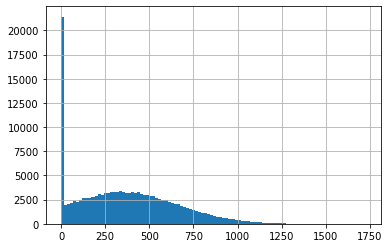

In [9]:
internet['mb_used'].hist(bins=100)

In [10]:
internet.isnull().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Пропусков нет, но много нулей. Сравним средний общий расход с нулями и без них:

In [11]:
internet['mb_used'].mean() # с нулями

370.1924263701839

In [12]:
internet.query('mb_used != 0')['mb_used'].mean() # и без них

426.08721035763267

Разница есть. При желании эти нули можно бы объяснить, что пользователи зачастую пользуются вай-фаем, могут использовать две симкарты  или не пользоваться интернетом вообще. Не стоит забывать, что в исходной таблице представлены СЕССИИ, а не суммарное пользование интернетом конкретным пользователем. Посмотрим, сколько в итоге пользователи расходовали трафик:

In [13]:
internet.pivot_table(index = 'user_id', values = 'mb_used', aggfunc = 'sum').sort_values('mb_used')

,mb_used
user_id,
1399,4603.52
1192,9031.84
1062,11072.78
1069,11348.27
1406,11430.43
...,...
1330,336373.28
1185,343533.71
1180,348211.20


Как мы видим, есть пользователи, которые интерентом практически не пользуются. Оставляем нули как есть и идем дальше.

Израсходованный интернет расчитывается аналогично телефонным звонкам - округляем "по потолку":

In [14]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil) #округляем к потолку
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000


Переводим дату в номер месяца:

In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date']).dt.month
internet.rename(columns={'session_date':'month'}, inplace=True)

Сводная таблица с расчетом использованного интеренета по месяцам:

In [16]:
internet_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc= 'sum')
internet_month.rename(columns={'sum':'mb_used'}, inplace=True)
internet_month.head(3)

mb_used
user_id month         
1000    5       2256.0
        6      23257.0
        7      14016.0

---
**Сообщения**

In [17]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

Переводим дату в номер месяца:

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date']).dt.month
messages.rename(columns={'message_date':'month'}, inplace=True)

Сделаем сводную таблицу с расчетом количества сообщений:

In [20]:
messages_month = messages.pivot_table(index=['user_id', 'month'], aggfunc='count')
messages_month.rename(columns={'id': 'messages'}, inplace=True)
messages_month.head(3)

messages
user_id month          
1000    5            22
        6            60
        7            75

---
**Пользователи и тарифы**

In [21]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [22]:
users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [23]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Всего - 500 пользователей, пропуски только в столбце даты прекращения пользования тарифом, что означает, что 462 пользоватля продолжают пользоваться тарифами 

## Объединим полученные данные:
Для этого соединим таблицы звонков, сообщений, интернета и данных пользователей:

In [24]:
df1 = pd.merge(calls_month, messages_month, on=['user_id', 'month'], how='outer') # звонки и сообщения
df2 = pd.merge(df1, internet_month, on=['user_id', 'month'], how='outer') # + интернет
df2 = df2.reset_index().sort_values(by='user_id') # разделим индексы и отсортируем
df = pd.merge(df2, users, on='user_id', how='left') # добавим клинетов

Взглянем на пропуски:

In [25]:
df.isnull().sum()

user_id          0
month            0
calls           40
minutes         40
messages       497
mb_used         11
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Данные пропуски образовались при объединении таблиц, объяснить это можно тем, что не все пользователи пользуются звонками/сообщениями/интернетом.

Обработаем пропуски в нужных столбцах и переведем к целочисленному виду:

In [26]:
df[['calls', 'minutes', 'messages', 'mb_used']] = df[['calls', 'minutes', 'messages', 'mb_used']].fillna(0)
df[['calls', 'minutes', 'messages', 'mb_used']] = df[['calls', 'minutes', 'messages', 'mb_used']].astype('int')
df.isnull().sum()

user_id          0
month            0
calls            0
minutes          0
messages         0
mb_used          0
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Теперь данные имеют вид:

In [47]:
df.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,gb_used,total_cost
0,1000,5,22,159,22,2256,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.203125,1950.0
1,1000,6,43,172,60,23257,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.711914,1950.0
2,1000,7,47,340,75,14016,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,13.687500,1950.0
3,1000,8,52,408,81,14070,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,13.740234,1950.0
4,1000,9,58,466,57,14581,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,14.239258,1950.0


Проверим, все ли пользователи попали в конечный датасет:

In [50]:
users.query('user_id not in @df.user_id')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Двух пользователей нет. Скорее всего они не пользовались "благами" тарифа вообще, проверим это по их вхождению в df2(он формировался по параметру "outer" - объединяющему данные, поэтому на этом этапе их потеря невозможна):

In [67]:
df2.query('user_id == 1128 or user_id == 1371')

,user_id,month,calls,minutes,messages,mb_used


Так и есть. Идем дальше.

Для последующих работ переведем мегабайты в гигабайты

In [28]:
df['gb_used'] = df['mb_used']/1024

## Рассчитаем помесячную выручку с каждого пользователя:

Для чего создадим функцию, которая будет считать перерасходы и выводить общие расходы пользователя:

In [29]:
def total_cost(row):
    user = row['user_id']
    if row['tariff'] == "smart":
        tariff_data = tariffs.loc[0]
    else:
        tariff_data = tariffs.loc[1]
    # расчет перерасхода минут 
    if row['minutes'] <= tariff_data['minutes_included']:
        more_minutes = 0
    else:
        more_minutes = (row['minutes'] - tariff_data['minutes_included'])*tariff_data['rub_per_minute']
        # расчет перерасхода сообщений
    if row['messages'] <= tariff_data['messages_included']:
        more_messages = 0
    else:
        more_messages = (row['messages'] - tariff_data['messages_included'])*tariff_data['rub_per_message']
    # расчет перерасхода интернета
    if row['mb_used'] <= tariff_data['mb_per_month_included']:
        more_internet = 0
    else:
        more_internet = (row['mb_used'] - tariff_data['mb_per_month_included'])/1024*tariff_data['rub_per_gb']
    # расчет итоговой стоимости
    total_cost = tariff_data['rub_monthly_fee'] + more_minutes + more_messages + more_internet
    return total_cost

Примечание - у словиях проекта говорится, что тариф округляет мегабайты до целых, но не говорится, как ситуация обстоит с гигагабайтами. Поэтому мы без округлений умножаем перерасход Мб (переведенные в Гб) на стоимость дополнительных Гб

In [30]:
df['total_cost'] = df.apply(total_cost, axis=1) #применяем эту функцию

Взглянем на данные столбца:

1950.000000    851
550.000000     564
589.000000       7
604.000000       6
592.000000       6
              ... 
1110.546875      1
735.054688       1
685.000000       1
2570.507812      1
1539.968750      1
Name: total_cost, Length: 1593, dtype: int64

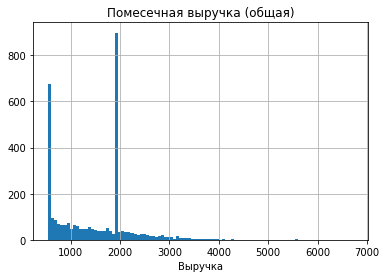

In [90]:
df['total_cost'].hist(bins=100).set_title('Помесечная выручка (общая)')
plt.xlabel('Выручка')
df['total_cost'].value_counts()

Большое количество пользователей не превышают лимиты, что выливается в пики на 550 и 1950 рублей - базовые стоимости пакетов/

Взглянем на картину каждого тарифа:

Text(0.5, 0, 'Выручка')

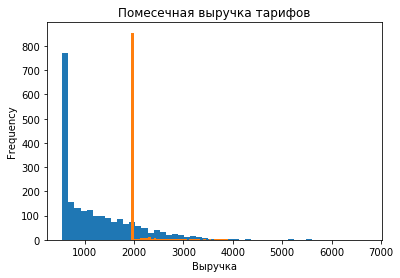

In [87]:
df.query('tariff == "smart"')['total_cost'].plot(kind='hist', bins=50).set_title('Помесечная выручка тарифов')
df.query('tariff == "ultra"')['total_cost'].plot(kind='hist', bins=50)
plt.xlabel('Выручка')

Получается, что пользователи тарифа "смарт" намного чаще превышают лимиты пакета и платят дополнительно, чем пользователи тарифа "ультра". Но на этом этапе рано судить о том, какой тариф более интересен бизнесу

**Вывод**

Из представленных данных, мы сделали промежуточные сводные таблицы, которые объединили в общую и рассчитали помесячную выручку с каждого пользователя:

In [75]:
df.head(3)

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,gb_used,total_cost
0,1000,5,22,159,22,2256,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2.203125,1950.0
1,1000,6,43,172,60,23257,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.711914,1950.0
2,1000,7,47,340,75,14016,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,13.687500,1950.0


# 2. Анализ

**Рассмотрим сколько минут разговора, сообщений и объём трафика требуется пользователям каждого тарифа в месяц**

Сделаем сводную таблицу с расчетом необходимых параметров ('mean' - среднее, 'var' -дисперсия для выборки, 'std' - стандартное отклонение):

In [32]:
stat = df.pivot_table(index='tariff', values=['minutes', 'messages', 'gb_used'], aggfunc=('mean', 'var', 'std'))
stat.round(1)

gb_used            messages               minutes                 
          mean  std   var     mean   std     var    mean    std       var
tariff                                                                   
smart     15.8  5.7  32.9     33.4  28.2   796.8   417.9  190.3   36219.3
ultra     19.0  9.9  97.2     49.4  47.8  2285.3   526.6  317.6  100873.6

**Рассмотрим гистограммы параметров**

Для начала сделаем список столбцов с необходимыми параметрами и разделим df по тарифам:

In [33]:
column_list = ['minutes', 'messages', 'mb_used']
smart = df.query('tariff == "smart"')
ultra = df.query('tariff == "ultra"')

Строим гистограммы для тарифа "smart":

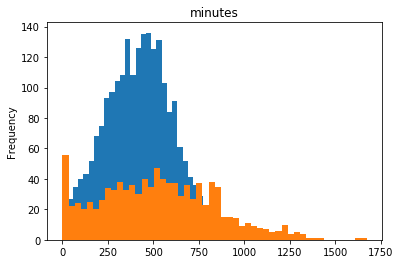

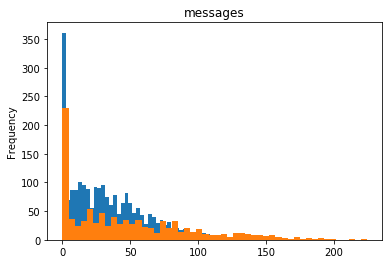

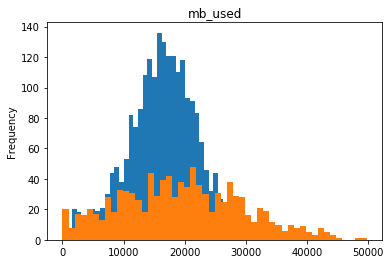

In [77]:
for i in df.columns:
    if i in column_list:
        fig = plt.figure()
        smart[i].plot(kind='hist', bins=50, title=i)
        ultra[i].plot(kind='hist', bins=50, title=i)

И для тарифа "ultra":

**Вывод**

Сводные цифры говрят о том, что пользователи тарифа "Ультра" в среднем больше разговаривают по телефону, отправляют СМС и пользуются интернетом, аналоничным образом разнятся и дисперсии и средние отклонения этих показателей:

In [36]:
stat.round(1)

gb_used            messages               minutes                 
          mean  std   var     mean   std     var    mean    std       var
tariff                                                                   
smart     15.8  5.7  32.9     33.4  28.2   796.8   417.9  190.3   36219.3
ultra     19.0  9.9  97.2     49.4  47.8  2285.3   526.6  317.6  100873.6

# 3. Проверка гипотез:
- Г1 Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- Г2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов



**3.1 Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

В качестве нулевой возьмем равенство выручки, а за альтернативную - гипотезу из задания,
- Н0 - Cредняя выручка тарифов «Ультра» равна выручке тарифа «Смарт»
- Н1 - Cредние выручки тарифов различаются

Рассмотрим дисперсии сравниваемых данных:

In [37]:
print('Дисперсия выручки тарифа «Ультра»: {:.2f}'.format(np.var(smart['total_cost'], ddof=1)))
print('Дисперсия выручки тарифа «Смарт»: {:.2f}'.format(np.var(ultra['total_cost'], ddof=1)))

Дисперсия выручки тарифа «Ультра»: 620452.61
Дисперсия выручки тарифа «Смарт»: 126953.29


Дисперсии сильно разнятся, поэтому добавляем параметр "equal_var = False"

In [114]:
alpha = .05
results = st.ttest_ind(smart['total_cost'], ultra['total_cost'], equal_var = False)

print('p-значение', results.pvalue)

if (results.pvalue < alpha): ### ошибка **upd: исправлено**
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не удалось')    

p-значение 8.931402711368788e-296
Отвергаем нулевую гипотезу


Сравним средние показатели:

In [111]:
print('Средняя выручка тарифа "Смарт": {:.1f}'.format(smart['total_cost'].mean()))
print('Средняя выручка тарифа "Ультра": {:.1f}'.format(ultra['total_cost'].mean()))
print('"Ультра" / "Смарт" = {:.1f}'.format(ultra['total_cost'].mean()/smart['total_cost'].mean()))

Средняя выручка тарифа "Смарт": 1233.3
Средняя выручка тарифа "Ультра": 2060.5
"Ультра" / "Смарт" = 1.7


**Похоже на то, что выручки у тарифов действительно отличаются. Судя по р-значению, такая вероятность очень велика.**

**Средние показатели говорят, что выручка тарифа "Ультра" существенно выше "Смарт"**

---
**3.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Снова в качестве нулевой возьмем саму гипотезу из задания:
- Н0 - Средняя выручка пользователей из Москвы равна выручке пользователей других городов
- Н1 - Cредние выручки в Москве и других городах различаются

Создадим отдельные датасеты с пользователями из Москвы/других городов и посчитаем дисперсии выручки:

In [39]:
moscow = df.query('city == "Москва"')
other_sity = df.query('city != "Москва"')
print('Дисперсия выручки в Москве: {:.2f}'.format(np.var(moscow['total_cost'], ddof=1)))
print('Дисперсия выручки в других городах: {:.2f}'.format(np.var(other_sity['total_cost'], ddof=1)))

Дисперсия выручки в Москве: 547242.75
Дисперсия выручки в других городах: 630503.85


В этом случае разница между дисперсиями не такая большая, поэтому задаем параметр "equal_var" не задаем, а по умлочанию он равен "True"

In [92]:
alpha = .05
results = st.ttest_ind(moscow['total_cost'], other_sity['total_cost'])

print('p-значение', results.pvalue)

if (results.pvalue < alpha): ### ошибка
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не удалось')

p-значение 0.47443187631524797
Нулевую гипотезу отвергнуть не удалось


**Р-значение ощутимо больше альфы, с большой вероятностью можно полагать, что средняя выручка между Москвой и остальными городами не отличается**

## Выводы

### **В рамках работ нами проанализированы показатели двух тарифных планов: «Смарт» и «Ультра»:**
- определены количество звонков/минут разговора/СМС/трафика по месяцам
- расчитана помесячная выручку с каждого пользователя
- описано поведение пользователей в части используемых едениц тарифа в месяц:

**Сводные цифры говрят о том, что пользователи тарифа "Ультра" в среднем больше разговаривают по телефону, отправляют СМС и пользуются интернетом**

### Проверены гипотезы:

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различается?
   
**Гипотезу отвергунть не удалось. Это означает, что выручки у тарифов, возможно, действительно отличаются. Судя по р-значению, такая вероятность очень велика**
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов?
    
**Гипотеза отвергута. С большой вероятностью можно полагать, что средняя выручка между Москвой и остальными городами не отличается**